<a href="https://colab.research.google.com/github/illusoryTwin/Adversarial-robustness/blob/main/task1/ML_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp drive/MyDrive/ML/Assignment2/task_1_train_data.json task_1_train_data.json
!cp drive/MyDrive/ML/Assignment2/task_1_verify.json task_1_verify.json

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import pytz
import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import torch
from torch import nn

# Exploring the dataset

In [5]:
# Upload the dataset

data = pd.read_json('task_1_train_data.json')
verify_dataset = pd.read_json('task_1_verify.json')

In [6]:
# Let's check the data types in each column

data.dtypes

browser             object
os                  object
locale              object
user_id              int64
location            object
sites               object
time                object
date        datetime64[ns]
dtype: object

In [7]:
# Check the contet of the dataset

data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   browser   40000 non-null  object        
 1   os        40000 non-null  object        
 2   locale    40000 non-null  object        
 3   user_id   40000 non-null  int64         
 4   location  40000 non-null  object        
 5   sites     40000 non-null  object        
 6   time      40000 non-null  object        
 7   date      40000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 2.4+ MB


,browser,os,locale,user_id,location,sites,time,date
0,Chrome,Debian,ur-PK,116,Russia/Moscow,"[{'site': 'bing.net', 'length': 52}, {'site': ...",04:12:00,2017-06-29
1,Firefox,Windows 8,uk-UA,155,France/Paris,"[{'site': 'yahoo.com', 'length': 46}, {'site':...",03:57:00,2016-03-23
2,Safari,MacOS,fr-FR,39,Japan/Tokyo,"[{'site': 'oracle.com', 'length': 335}]",05:26:00,2016-11-17
3,Chrome,Windows 8,nl-NL,175,Australia/Sydney,"[{'site': 'mail.google.com', 'length': 192}, {...",00:05:00,2016-08-23
4,Firefox,Ubuntu,ro-RO,50,USA/San Francisco,"[{'site': 'mail.google.com', 'length': 266}, {...",22:55:00,2016-07-23


In [8]:
# Let's check the missing values in each column

missing_values = data.isna().sum()
missing_values

browser     0
os          0
locale      0
user_id     0
location    0
sites       0
time        0
date        0
dtype: int64

In [9]:
# Check the unique instances of categorical features

target_columns = data[['browser', 'os', 'locale', 'location']]
target_columns

for column in target_columns:
  unique_values = target_columns[column].unique()
  print(unique_values)


['Chrome' 'Firefox' 'Safari' 'Internet Explorer']
['Debian' 'Windows 8' 'MacOS' 'Ubuntu' 'Windows 10' 'Windows 7']
['ur-PK' 'uk-UA' 'fr-FR' 'nl-NL' 'ro-RO' 'en-US' 'en-NZ' 'vi-VN' 'pt-BR'
 'es-MX' 'ja-JP' 'en-GB' 'en-SG' 'ru_RU' 'pt-PT' 'zh-CN' 'bg-BG' 'wo-SN'
 'de-DE' 'pl-PL' 'it-IT' 'xh-ZA' 'ru-RU' 'en-AU' 'en-CA']
['Russia/Moscow' 'France/Paris' 'Japan/Tokyo' 'Australia/Sydney'
 'USA/San Francisco' 'Canada/Vancouver' 'UK/London' 'Canada/Toronto'
 'Malaysia/Kuala Lumpur' 'USA/Miami' 'Italy/Rome' 'Spain/Madrid'
 'USA/Chicago' 'Germany/Berlin' 'China/Shanghai' 'India/Delhi'
 'Brazil/Rio de Janeiro' 'Singapore/Singapore' 'Netherlands/Amsterdam'
 'USA/New York' 'New Zealand/Auckland']


In [10]:
def find_instances_location(data):
    unique_values = data['location'].unique()
    substrings = set()
    for value in unique_values:
        substring = value.split('/')[0]
        substrings.add(substring)
    instances_dict = {substring: [value for value in unique_values if value.startswith(substring)] for substring in substrings}
    return instances_dict

# Find instances starting with the same substring before "/" in location column
location_instances = find_instances_location(data)
for substring, instances in location_instances.items():
    print(f"Instances starting with '{substring}': {instances}")



def find_instances_locale(data):
    unique_values = data['locale'].unique()
    substrings = set()
    for value in unique_values:
        substring = value.split('-')[0]
        substrings.add(substring)
    instances_dict = {substring: [value for value in unique_values if value.startswith(substring)] for substring in substrings}
    return instances_dict

# Find instances starting with the same substring before "-" in locale column
locale_instances = find_instances_locale(data)
for substring, instances in locale_instances.items():
    print(f"Instances starting with '{substring}': {instances}")



Instances starting with 'Italy': ['Italy/Rome']
Instances starting with 'Germany': ['Germany/Berlin']
Instances starting with 'USA': ['USA/San Francisco', 'USA/Miami', 'USA/Chicago', 'USA/New York']
Instances starting with 'India': ['India/Delhi']
Instances starting with 'Australia': ['Australia/Sydney']
Instances starting with 'Canada': ['Canada/Vancouver', 'Canada/Toronto']
Instances starting with 'UK': ['UK/London']
Instances starting with 'Brazil': ['Brazil/Rio de Janeiro']
Instances starting with 'Netherlands': ['Netherlands/Amsterdam']
Instances starting with 'Singapore': ['Singapore/Singapore']
Instances starting with 'New Zealand': ['New Zealand/Auckland']
Instances starting with 'China': ['China/Shanghai']
Instances starting with 'Japan': ['Japan/Tokyo']
Instances starting with 'Spain': ['Spain/Madrid']
Instances starting with 'Russia': ['Russia/Moscow']
Instances starting with 'France': ['France/Paris']
Instances starting with 'Malaysia': ['Malaysia/Kuala Lumpur']
Instances s

# Revealing the dependecies and anomalies in the dataset

### We can see that
- The distribution of instances across the Browser class is fairly balanced.
- There is a notable dominant class within the OS classes.
- The distribution of instances across the Locale and Location classes is fairly balanced

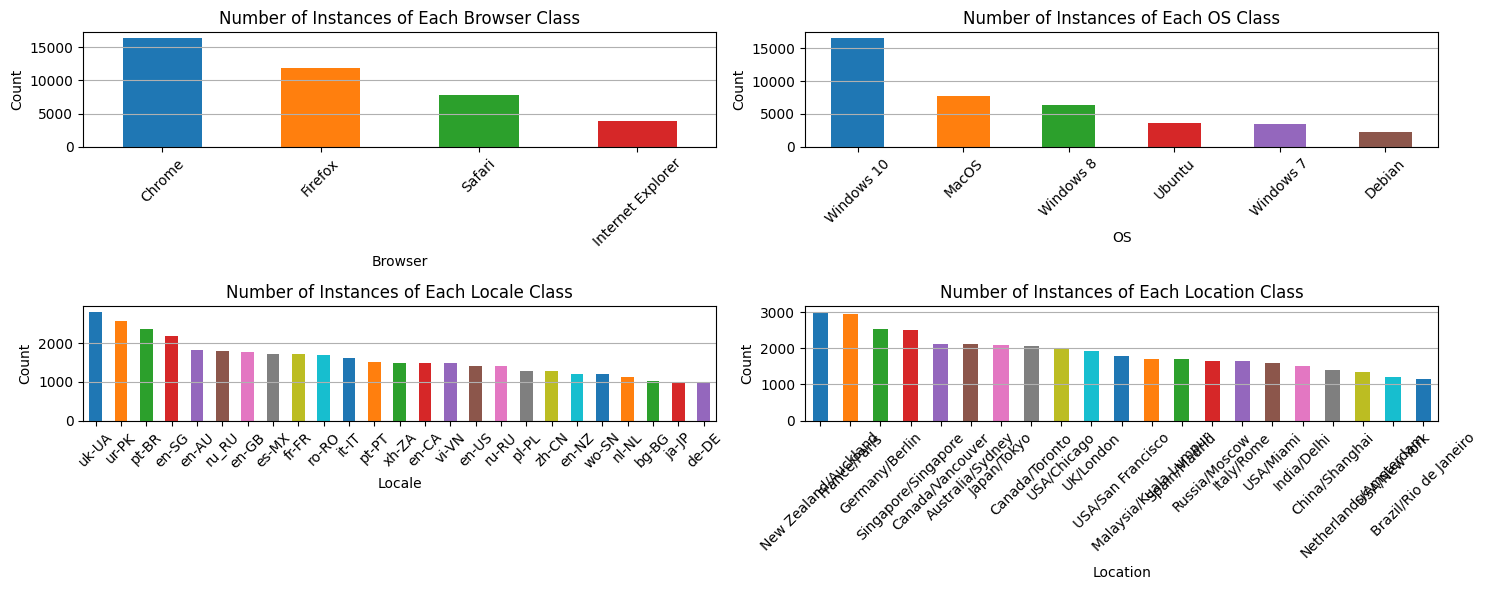

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

browser_counts = data['browser'].value_counts()
browser_counts.plot(kind='bar', ax=axes[0, 0], color=colors)
axes[0, 0].set_title('Number of Instances of Each Browser Class')
axes[0, 0].set_xlabel('Browser')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
axes[0, 0].grid(axis='y')  # Add grid lines along the y-axis

os_counts = data['os'].value_counts()
os_counts.plot(kind='bar', ax=axes[0, 1], color=colors)
axes[0, 1].set_title('Number of Instances of Each OS Class')
axes[0, 1].set_xlabel('OS')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(axis='y')

locale_counts = data['locale'].value_counts()
locale_counts.plot(kind='bar', ax=axes[1, 0], color=colors)
axes[1, 0].set_title('Number of Instances of Each Locale Class')
axes[1, 0].set_xlabel('Locale')
axes[1, 0].set_ylabel('Count')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(axis='y')

location_counts = data['location'].value_counts()
location_counts.plot(kind='bar', ax=axes[1, 1], color=colors)
axes[1, 1].set_title('Number of Instances of Each Location Class')
axes[1, 1].set_xlabel('Location')
axes[1, 1].set_ylabel('Count')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(axis='y')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [12]:
# Let's create the column with a day of the week for each session in the table

data['day_of_week'] = pd.to_datetime(data['date']).dt.day_name()
data

,browser,os,locale,user_id,location,sites,time,date,day_of_week
0,Chrome,Debian,ur-PK,116,Russia/Moscow,"[{'site': 'bing.net', 'length': 52}, {'site': ...",04:12:00,2017-06-29,Thursday
1,Firefox,Windows 8,uk-UA,155,France/Paris,"[{'site': 'yahoo.com', 'length': 46}, {'site':...",03:57:00,2016-03-23,Wednesday
2,Safari,MacOS,fr-FR,39,Japan/Tokyo,"[{'site': 'oracle.com', 'length': 335}]",05:26:00,2016-11-17,Thursday
3,Chrome,Windows 8,nl-NL,175,Australia/Sydney,"[{'site': 'mail.google.com', 'length': 192}, {...",00:05:00,2016-08-23,Tuesday
4,Firefox,Ubuntu,ro-RO,50,USA/San Francisco,"[{'site': 'mail.google.com', 'length': 266}, {...",22:55:00,2016-07-23,Saturday
...,...,...,...,...,...,...,...,...,...
39995,Chrome,Windows 10,wo-SN,184,Malaysia/Kuala Lumpur,"[{'site': 'airbnb.com', 'length': 96}, {'site'...",06:45:00,2016-04-03,Sunday
39996,Chrome,Windows 10,ru_RU,181,France/Paris,"[{'site': 'lenta.ru', 'length': 84}, {'site': ...",20:57:00,2016-12-28,Wednesday
39997,Safari,MacOS,en-GB,112,Australia/Sydney,"[{'site': 'toptal.com', 'length': 65}, {'site'...",04:12:00,2016-07-26,Tuesday
39998,Safari,MacOS,pt-BR,136,India/Delhi,"[{'site': 'yworks.com', 'length': 146}, {'site...",10:18:00,2017-01-01,Sunday


In [13]:
waldo_data = data[data['user_id']==0]
non_waldo_data = data[data['user_id']!=0]
waldo_data

,browser,os,locale,user_id,location,sites,time,date,day_of_week
95,Firefox,Ubuntu,ru_RU,0,USA/Chicago,"[{'site': 'mail.google.com', 'length': 75}, {'...",02:47:00,2016-11-05,Saturday
254,Firefox,Windows 10,ru_RU,0,France/Paris,"[{'site': 'lenta.ru', 'length': 43}, {'site': ...",20:52:00,2016-05-05,Thursday
292,Chrome,Windows 10,ru_RU,0,USA/Chicago,"[{'site': 'vk.com', 'length': 79}, {'site': 'm...",03:38:00,2017-05-12,Friday
366,Chrome,Windows 10,ru_RU,0,France/Paris,"[{'site': 'mail.google.com', 'length': 71}, {'...",11:04:00,2016-05-19,Thursday
435,Chrome,Windows 10,ru_RU,0,France/Paris,"[{'site': 'mail.google.com', 'length': 72}, {'...",20:22:00,2016-06-27,Monday
...,...,...,...,...,...,...,...,...,...
39073,Chrome,Ubuntu,ru_RU,0,USA/Chicago,"[{'site': 'youtube.com', 'length': 88}, {'site...",02:22:00,2017-03-24,Friday
39231,Chrome,Ubuntu,ru_RU,0,Canada/Toronto,"[{'site': 'mail.google.com', 'length': 87}, {'...",02:51:00,2017-08-25,Friday
39450,Chrome,Ubuntu,ru_RU,0,USA/Chicago,"[{'site': 'mail.google.com', 'length': 93}, {'...",02:39:00,2016-12-02,Friday
39893,Firefox,Ubuntu,ru_RU,0,Canada/Toronto,"[{'site': 'mail.google.com', 'length': 49}, {'...",17:27:00,2017-09-04,Monday


### Let's examine the correlation between features and beeing a Waldo.
We can notice that certain browser, location, locale, and OS types are definitely inherent to Waldo.



In [14]:
# Dependency on Location

print("Waldo locations:\n", waldo_data['location'].unique())
print("\nAll locations:\n", data['location'].unique())

Waldo locations:
 ['USA/Chicago' 'France/Paris' 'Canada/Toronto']

All locations:
 ['Russia/Moscow' 'France/Paris' 'Japan/Tokyo' 'Australia/Sydney'
 'USA/San Francisco' 'Canada/Vancouver' 'UK/London' 'Canada/Toronto'
 'Malaysia/Kuala Lumpur' 'USA/Miami' 'Italy/Rome' 'Spain/Madrid'
 'USA/Chicago' 'Germany/Berlin' 'China/Shanghai' 'India/Delhi'
 'Brazil/Rio de Janeiro' 'Singapore/Singapore' 'Netherlands/Amsterdam'
 'USA/New York' 'New Zealand/Auckland']


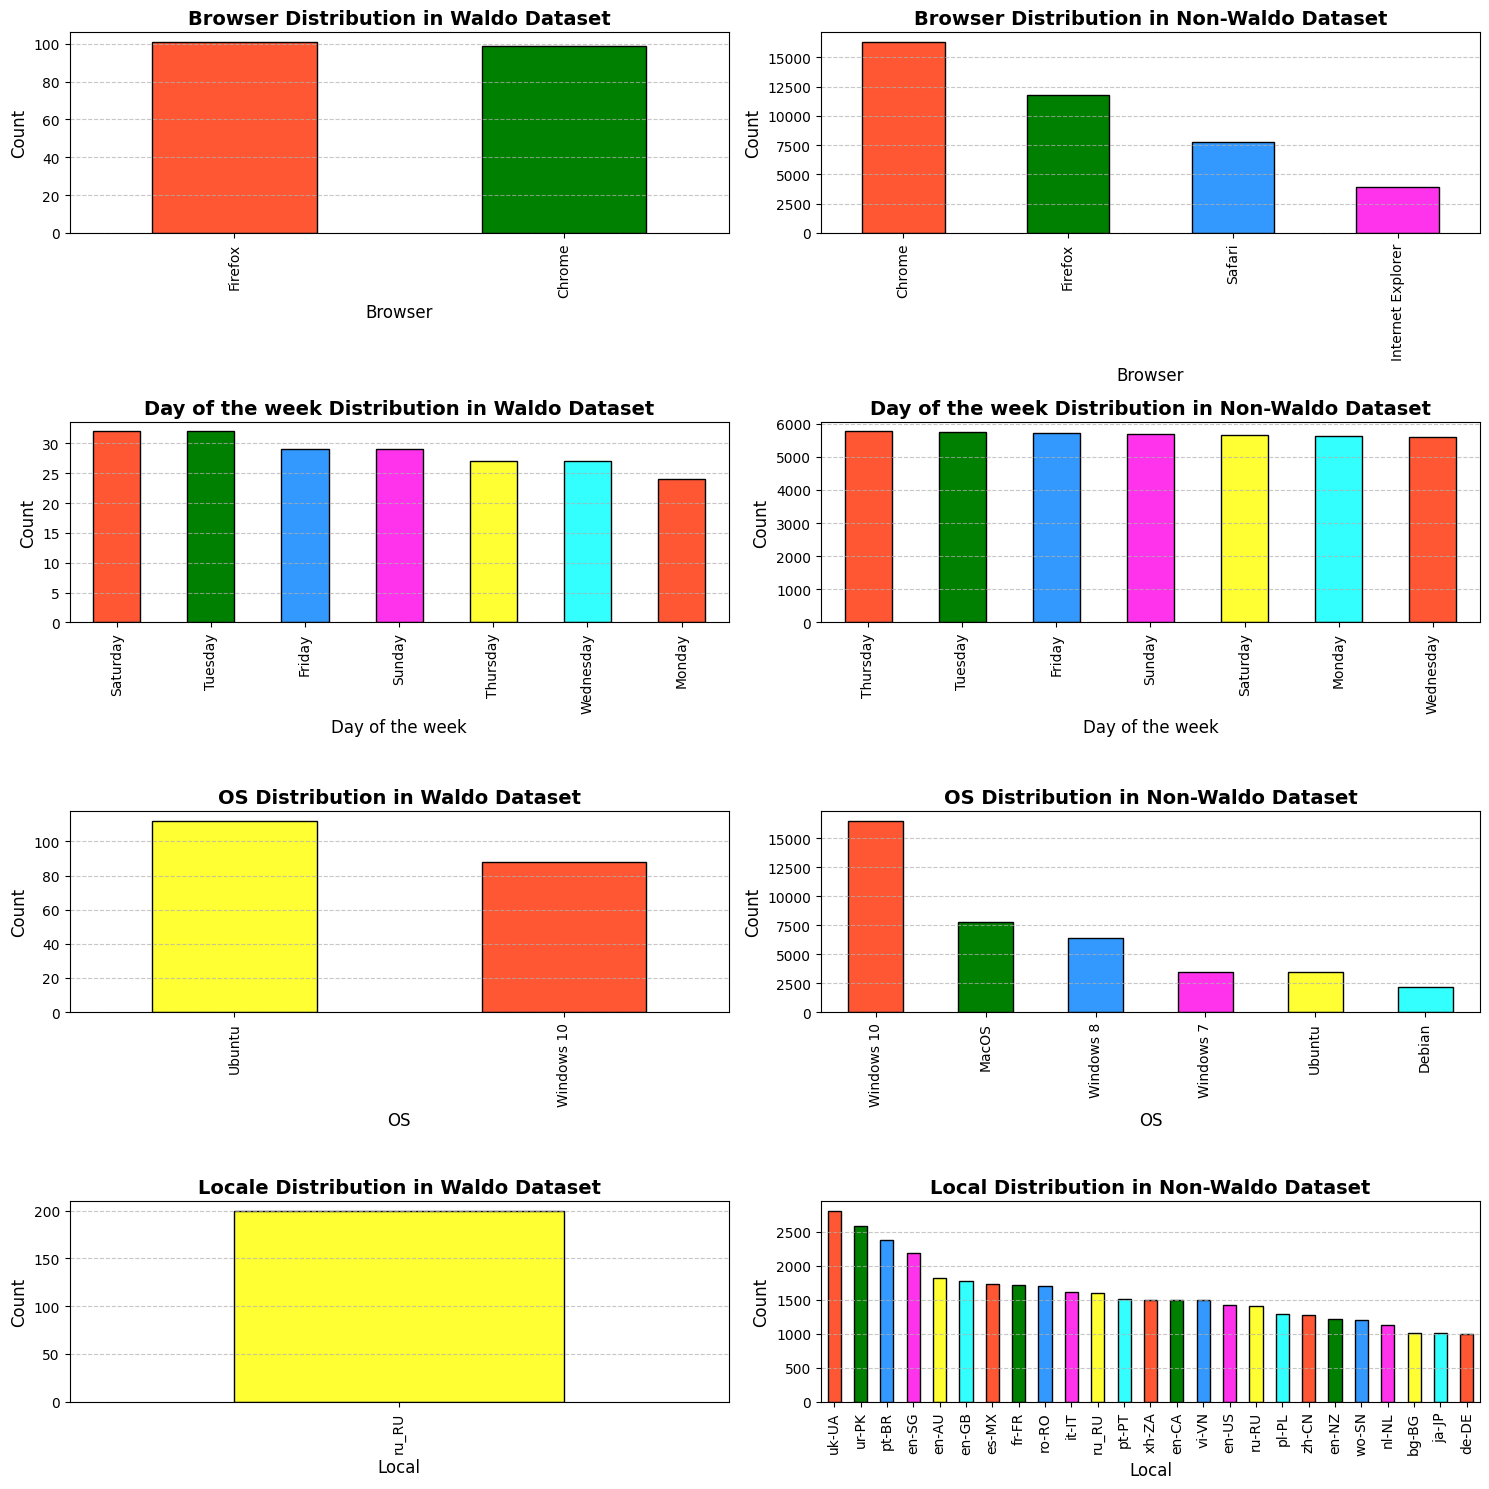

In [15]:
# Dependency on Browser, Day of the week, OS, and Locale

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# Define colors for the plots
colors = ['#FF5733', 'green', '#3399FF', '#FF33EC', '#FFFF33', '#33FFFF']
colors2 = ['#FFFF33', '#FF5733']

# Plot for Browser Distribution in Waldo Dataset
plt.subplot(421)
waldo_data['browser'].value_counts().plot(kind='bar', color=colors, edgecolor='black', linewidth=1)
plt.title('Browser Distribution in Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Browser', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Browser Distribution in Non-Waldo Dataset
plt.subplot(422)
non_waldo_data['browser'].value_counts().plot(kind='bar', color=colors, edgecolor='black', linewidth=1)
plt.title('Browser Distribution in Non-Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Browser', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Day of the week Distribution in Waldo Dataset
plt.subplot(423)
waldo_data['day_of_week'].value_counts().plot(kind='bar', color=colors, edgecolor='black', linewidth=1)
plt.title('Day of the week Distribution in Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Day of the week Distribution in Non-Waldo Dataset
plt.subplot(424)
non_waldo_data['day_of_week'].value_counts().plot(kind='bar', color=colors, edgecolor='black', linewidth=1)
plt.title('Day of the week Distribution in Non-Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Day of the week', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for OS Distribution in Waldo Dataset
plt.subplot(425)
waldo_data['os'].value_counts().plot(kind='bar', color=colors2, edgecolor='black', linewidth=1)
plt.title('OS Distribution in Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('OS', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for OS Distribution in Non-Waldo Dataset
plt.subplot(426)
non_waldo_data['os'].value_counts().plot(kind='bar', color=colors, edgecolor='black', linewidth=1)
plt.title('OS Distribution in Non-Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('OS', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


# Plot for Waldo Dataset
plt.subplot(427)
waldo_data['locale'].value_counts().plot(kind='bar', color=colors2, edgecolor='black', linewidth=1)
plt.title('Locale Distribution in Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Local', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Non-Waldo Dataset
plt.subplot(428)
non_waldo_data['locale'].value_counts().plot(kind='bar', color=colors, edgecolor='black', linewidth=1)
plt.title('Local Distribution in Non-Waldo Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Local', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)



plt.tight_layout()
plt.show()


### We can see that the dataset is not fairly balanced in terms of the number of waldo instances.

In [16]:
waldo_count = (data['user_id']==0).sum()
print("The number of  waldo instanes:", waldo_count, "\nThe size of the dataset:", len(data))


The number of  waldo instanes: 200 
The size of the dataset: 40000


# Data Preprocessing and Feature Engineering

In [25]:
# Upload the dataset

data = pd.read_json('task_1_train_data.json')
verify_dataset = pd.read_json('task_1_verify.json')

In [26]:
# Create the column target for waldo validation
data['target'] = (data.user_id == 0).apply(int)
data['target'].value_counts()

target
0    39800
1      200
Name: count, dtype: int64

In [27]:
# Encode cyclical features
def cyclic_encode(df, col, period):
    df[f'sin_{col}'] = np.sin(2 * np.pi * df[col].astype(int) / period)
    df[f'cos_{col}'] = np.cos(2 * np.pi * df[col].astype(int) / period)
    return df.drop(columns=[col])

In [28]:
# Define the locations based on UTC time location
def get_utc_timezone(location):
    timezone_mapping = {
        'Russia/Moscow': 'Europe/Moscow',
        'France/Paris': 'Europe/Paris',
        'Japan/Tokyo': 'Asia/Tokyo',
        'Australia/Sydney': 'Australia/Sydney',
        'USA/San Francisco': 'America/Los_Angeles',
        'Canada/Vancouver': 'America/Vancouver',
        'UK/London': 'Europe/London',
        'Canada/Toronto': 'America/Toronto',
        'Malaysia/Kuala Lumpur': 'Asia/Kuala_Lumpur',
        'USA/Miami': 'America/New_York',
        'Italy/Rome': 'Europe/Rome',
        'Spain/Madrid': 'Europe/Madrid',
        'USA/Chicago': 'America/Chicago',
        'Germany/Berlin': 'Europe/Berlin',
        'China/Shanghai': 'Asia/Shanghai',
        'India/Delhi': 'Asia/Kolkata',
        'Brazil/Rio de Janeiro': 'America/Sao_Paulo',
        'Singapore/Singapore': 'Asia/Singapore',
        'Netherlands/Amsterdam': 'Europe/Amsterdam',
        'USA/New York': 'America/New_York',
        'New Zealand/Auckland': 'Pacific/Auckland'
    }
    return timezone_mapping.get(location, None)



### Retrieve features from the dataset and create corresponding columns: browser, os, locale, location, day, month, weekday, hour, minute. The time is defined as local based on the location

In [29]:
def prepare_dataframe(df: pd.DataFrame):

    def convert_to_local_time(row):
        location_for_utc = row['location_for_utc']
        time_str = row['time']  # Use only the time string
        input_time = datetime.strptime(time_str, '%H:%M:%S')  # Parse time only
        utc_timezone = pytz.timezone('UTC')
        local_timezone = pytz.timezone(location_for_utc)
        utc_time = utc_timezone.localize(input_time)
        local_time = utc_time.astimezone(local_timezone)
        return local_time.strftime('%H:%M:%S')
    df['location_for_utc'] = df['location'].apply(get_utc_timezone)

    df['local_time'] = df.apply(convert_to_local_time, axis=1)

    df['day'] = df['date'].apply(lambda x: x.day)
    df['month'] = df['date'].apply(lambda x: x.month)
    df['weekday'] = df['date'].apply(lambda x: x.day_of_week)

    df['browser'] = pd.Categorical(df['browser'])
    df['os'] = pd.Categorical(df['os'])
    df['locale'] = pd.Categorical(df['locale'])
    df['location'] = pd.Categorical(df['location'])

    df['hour'] = df['local_time'].apply(lambda x: int(str(x).split(':')[0]))
    df['minute'] = df['local_time'].apply(lambda x: int(str(x).split(':')[1]))
    # df['sites_lengths'] = df['sites'].apply(lambda x: len(x))

    df = cyclic_encode(df, 'day', 365)
    df = cyclic_encode(df, 'month', 12)
    df = cyclic_encode(df, 'weekday', 7)
    df = cyclic_encode(df, 'hour', 24)
    df = cyclic_encode(df, 'minute', 60)

    return df.drop(columns=['sites', 'time', 'date', 'location_for_utc', 'local_time'])

y = data['target']
X = data.drop(columns=['target', 'user_id'])
train_df = prepare_dataframe(X)
train_df.head()

,browser,os,locale,location,sin_day,cos_day,sin_month,cos_month,sin_weekday,cos_weekday,sin_hour,cos_hour,sin_minute,cos_minute
0,Chrome,Debian,ur-PK,Russia/Moscow,0.478734,0.877960,1.224647e-16,-1.000000e+00,0.433884,-0.900969,1.000000,6.123234e-17,-0.951057,-3.090170e-01
1,Firefox,Windows 8,uk-UA,France/Paris,0.385663,0.922640,1.000000e+00,6.123234e-17,0.974928,-0.222521,0.866025,5.000000e-01,0.587785,8.090170e-01
2,Safari,MacOS,fr-FR,Japan/Tokyo,0.288482,0.957485,-5.000000e-01,8.660254e-01,0.433884,-0.900969,-0.500000,-8.660254e-01,-1.000000,-1.836970e-16
3,Chrome,Windows 8,nl-NL,Australia/Sydney,0.385663,0.922640,-8.660254e-01,-5.000000e-01,0.781831,0.623490,0.500000,-8.660254e-01,0.866025,5.000000e-01
4,Firefox,Ubuntu,ro-RO,USA/San Francisco,0.385663,0.922640,-5.000000e-01,-8.660254e-01,-0.974928,-0.222521,-0.707107,-7.071068e-01,0.207912,9.781476e-01


In [30]:
# Encode categorical features
ohe = OneHotEncoder(sparse_output=False)

ohe_data = ohe.fit_transform(train_df[['browser','os','locale','location']])
train_data = np.concatenate((ohe_data, train_df.drop(columns=['browser','os','locale','location']).values), axis=1)


In [31]:
# Scale the data
scale = StandardScaler()
train_data = scale.fit_transform(train_data)

In [32]:
# Create a train and test data
x_train, x_val, y_train, y_val = train_test_split(train_data, y, shuffle=True, stratify=y, test_size=0.2, random_state=42)

In [35]:

class ANN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ANN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch_x_train = torch.tensor(x_train, dtype=torch.float32)
torch_x_val = torch.tensor(x_val, dtype=torch.float32)

torch_y_train = torch.tensor(y_train.values, dtype=torch.long)
torch_y_val = torch.tensor(y_val.values, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(torch_x_train, torch_y_train)
val_dataset = torch.utils.data.TensorDataset(torch_x_val, torch_y_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2048)

In [38]:

def train(model, loss_fn, optim, train_dataloader, scheduler=None):
    model.train()
    losses = []
    for inp, target in train_dataloader:
        inp = inp.to(device)
        inp.requires_grad = True
        target = target.to(device)
        optim.zero_grad()

        preds = model(inp)
        loss = loss_fn(preds, target)
        loss.backward()
        optim.step()
        losses.append(loss.item())
    return np.mean(losses)

def validation(model, val_dataloader, score_fn):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inp, target in val_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            preds = model(inp).cpu().detach().numpy().argmax(axis=1)
            y_pred.append(preds)
            y_true.append(target.cpu().detach().numpy())
    y_pred = np.hstack(y_pred)
    y_true = np.hstack(y_true)

    return score_fn(y_pred, y_true)



model = ANN(x_train.shape[-1], 2)
model.to(device)
weight=torch.tensor([0.1, 0.9], dtype=torch.float32, device=device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=.9)

epochs = 50
best_model_path = 'best.pth'
best_score = 0
patience = 20
pbar = tqdm(range(epochs))
for e in pbar:
    # print(f"{e + 1}/{epochs} Train loss:", train(model, loss_fn, optim, train_dataloader))
    train(model, loss_fn, optim, train_dataloader, scheduler)
    scheduler.step()
    val_score = validation(model, val_dataloader, sklearn.metrics.f1_score)
    if val_score > best_score:
        torch.save(model.state_dict(), best_model_path)
        best_score = val_score
    else:
        patience -= 1
    if patience == 0:
        break

    pbar.set_postfix({'val_score': val_score, 'best_score': best_score})

 48%|████▊     | 24/50 [01:30<01:38,  3.79s/it, val_score=0.61, best_score=0.656]


In [39]:
best_model = ANN(x_train.shape[-1], 2)
best_model.to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

ANN(
  (model): Sequential(
    (0): Linear(in_features=66, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=64, bias=True)
    (4): ReLU()
    (5): Linear(in_features=64, out_features=16, bias=True)
    (6): ReLU()
    (7): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [40]:
best_model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inp, target in val_dataloader:
        inp = inp.to(device)
        target = target.to(device)
        preds = best_model(inp).cpu().detach().numpy().argmax(axis=1)
        y_pred.append(preds)
        y_true.append(target.cpu().detach().numpy())
y_pred = np.hstack(y_pred)
y_true = np.hstack(y_true)

print(sklearn.metrics.classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9975    0.9999    0.9987      7960
           1     0.9524    0.5000    0.6557        40

    accuracy                         0.9974      8000
   macro avg     0.9749    0.7499    0.8272      8000
weighted avg     0.9973    0.9974    0.9970      8000



In [41]:
def validation(model, val_dataloader, score_fn):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inp in val_dataloader:
            inp = inp[0]
            inp = inp.to(device)
            preds = model(inp).cpu().detach().numpy().argmax(axis=1)
            y_pred.append(preds)
    y_pred = np.hstack(y_pred)

    return y_pred

In [44]:
verify_df = prepare_dataframe(verify_dataset)
ohe_data_verify = ohe.fit_transform(verify_df[['browser','os','locale','location']])
verify_data = np.concatenate((ohe_data_verify, verify_df.drop(columns=['browser','os','locale','location']).values), axis=1)

verify_data = scale.fit_transform(verify_data)


torch_verify = torch.tensor(verify_data, dtype=torch.float32)
verify_dataset = torch.utils.data.TensorDataset(torch_verify)
verify_dataloader = torch.utils.data.DataLoader(verify_dataset, batch_size=32)
test_labels = validation(best_model, verify_dataloader, best_score)

# Print the number of Waldo instances in verify dataset
len([x for x in test_labels if x == 1])

IndexError: too many indices for tensor of dimension 2